In [1]:
import argparse

from tqdm import trange, tqdm
import random
import pandas as pd
from copy import deepcopy

from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

import os
import math
import numpy as np

import torch
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader
from datasets import load_dataset
from tqdm import tqdm
from argparse import Namespace

from GeospatialFM.datasets.GFMBench.utils import get_dataset, get_metadata
from GeospatialFM.data_process import get_transform
from GeospatialFM.finetune.utils import get_task_model, get_loss_fn
from GeospatialFM.finetune.args import parse_args
from GeospatialFM.models import SpatialSpectralLowRankViTConfig, SpatialSpectralMAEViT
from GeospatialFM.finetune.linear_probe import compute_encoding
from GeospatialFM.data_process.collate_func import modal_specific_collate_fn

from datasets.fingerprint import Hasher

from functools import partial
from accelerate import Accelerator
from transformers import TrainingArguments
from safetensors import safe_open

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import rasterio
import pandas as pd
import json
from sklearn.decomposition import PCA

%load_ext autoreload
%autoreload 2

import time

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EUROSAT_CLS = [
    "Annual Crop",
    "Forest",
    "Herbaceous Vegetation",
    "Highway",
    "Industrial Buildings",
    "Pasture",
    "Permanent Crop",
    "Residential Buildings",
    "River",
    "Sea & Lake"
]

In [3]:
ROOT_DIR="/home/haozhesi/GeospatialFM"

In [4]:
EMBED_DIMS = 2
DEPTH = 4
CHECKPOINT = 24500
MOE = 0
SCALE = 1
TOPK = 1
DATASET = "eurosat"

args = parse_args([
    "--data_dir", ROOT_DIR + "/data/geospatial/",
    "--dataset_name", DATASET,
    "--task_type", "classification",
    "--scale", "1",
    "--modal", "optical", 
    "--return_dict",
    "--per_device_train_batch_size", "32",
    "--gradient_accumulation_steps", "2",
    "--num_train_epochs", "20", 
    "--learning_rate", "1e-4",
    "--weight_decay", "0.01",
    "--warmup_steps", "0",
    "--warmup_ratio", "0.2",
    "--report_to", "none",
    "--save_total_limit", "5",
    "--seed", "42",
    "--mixed_precision", "bf16",
    "--dataloader_num_workers", "32",
    "--dataloader_pin_memory",
    "--output_dir", ROOT_DIR + "/results/models",
    "--logging_dir", ROOT_DIR + "/results/logs",
    "--wandb_dir", ROOT_DIR + "/results/",
    "--run_name", f"LESSVIT_b{EMBED_DIMS}_d{DEPTH}_c{CHECKPOINT}_{DATASET}_moe{MOE}_topk{TOPK}_scale{SCALE}",
    "--lr_scheduler_type", "cosine",
    "--channel_embed_dims_per_head", str(EMBED_DIMS),
    "--use_perception_field_mask",
    "--pretrained_model_path", f"{ROOT_DIR}/results/models/LESSVIT_b{EMBED_DIMS}_d{DEPTH}/checkpoint-{CHECKPOINT}/model.safetensors",
    "--use_moe",
    "--num_experts", str(MOE),
    "--attention_radius", "640",
    "--n_trials", "10",
    "--use_early_stopping",
    "--early_stopping_patience", "5", 
    "--topk", str(TOPK),
    "--init_values", "1.0",
])

In [5]:
metadata = get_metadata(args.dataset_name)
args.crop_size = metadata["size"] if args.crop_size is None else args.crop_size

optical_mean, optical_std = metadata["s2c"]["mean"], metadata["s2c"]["std"]
radar_mean, radar_std = metadata["s1"]["mean"], metadata["s1"]["std"]

collate_fn = partial(modal_specific_collate_fn, modal=args.modal)

train_transform, eval_transform = get_transform(args.task_type, args.crop_size, args.scale, args.random_rotation, 
                                                optical_mean, optical_std, radar_mean, radar_std)
dataset = get_dataset(args, train_transform, eval_transform)

{"s2c": {"bands": ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"], "channel_wv": [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 945.1, 1373.5, 1613.7, 2202.4], "mean": [1354.40546513, 1118.24399958, 1042.92983953, 947.62620298, 1199.47283961, 1999.79090914, 2369.22292565, 2296.82608323, 732.08340178, 12.11327804, 1819.01027855, 1118.92391149, 2594.14080798], "std": [245.71762908, 333.00778264, 395.09249139, 593.75055589, 566.4170017, 861.18399006, 1086.63139075, 1117.98170791, 404.91978886, 4.77584468, 1002.58768311, 761.30323499, 1231.58581042]}, "s1": {"bands": null, "channel_wv": null, "mean": null, "std": null}, "size": 64, "num_classes": 10, "spatial_resolution": 10}
{"s2c": {"bands": ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"], "channel_wv": [442.7, 492.4, 559.8, 664.6, 704.1, 740.5, 782.8, 832.8, 864.7, 945.1, 1373.5, 1613.7, 2202.4], "mean": [1354.40546513, 1118.24399958, 1042.92983953, 9

In [6]:
# Initialize model
model = get_task_model(args, metadata["num_classes"], metadata["size"])
# load from checkpoint if provided
if args.pretrained_model_path:
    model.load_pretrained_encoder(args.pretrained_model_path)

In [7]:
if args.freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

if args.gradient_checkpointing:
    model.gradient_checkpointing_enable()
    
encoder = model.encoder
task_head = model.classifier
encoder.cuda().eval()

# preprocess dataset
compute_encoding_fn = partial(compute_encoding, model=encoder, task_type=args.task_type, modal=args.modal)

for split, dataset_split in dataset.items():
    if split == 'val':
        continue
    # new_fingerprint_for_encoder = Hasher.hash((args.pretrained_model_path, args.modal, args.dataset_name, split, args.scale))
    # feature_dataset = dataset_split.map(compute_encoding_fn, batched=True, batch_size=64, new_fingerprint=new_fingerprint_for_encoder)
    feature_dataset = dataset_split.map(compute_encoding_fn, batched=True, batch_size=64)
    feature_dataset.remove_columns(['spatial_resolution'])
    if 'optical' in feature_dataset.column_names: feature_dataset.remove_columns(['optical', 'optical_channel_wv'])
    if 'radar' in feature_dataset.column_names: feature_dataset.remove_columns(['radar', 'radar_channel_wv'])
    feature_dataset.set_format(type='torch')
    dataset[split] = feature_dataset
    
del encoder
del model.encoder
model = task_head

Map:  76%|███████▌  | 12288/16200 [04:40<01:29, 43.84 examples/s]


OSError: [Errno 28] No space left on device

In [8]:
method_feature = dict(LESSVIT = dataset)

In [9]:
dataset['test']['features'].shape

torch.Size([5400, 14, 768])

In [10]:
for key in method_feature:
    knn = KNeighborsClassifier(n_neighbors=20, metric='cosine')
    # knn = KNeighborsClassifier(n_neighbors=20) 
    knn.fit(method_feature[key]['train']['features'][:, 0, :], method_feature[key]['train']['labels'])
    y_pred = knn.predict(method_feature[key]['test']['features'][:, 0, :])
    acc = accuracy_score(method_feature[key]['test']['labels'], y_pred)
    print(f'{key} accuracy: {acc*100:.2f}%')
    method_feature[key]['knn_acc'] = acc

LESSVIT accuracy: 90.37%


In [11]:
# # extact the model ame from the directory name, it should between the dataset name and the 'finetune'
# # model_name = target_dirs[i].split(dataset+'_')[1].split('_finetune')[0]
# method_feature = dict()
# for name, fname in vis_content.items():
#     model_name = name
#     target_dir = fname
#     cached_exp = os.path.join(cache_path, target_dir)
#     label = dict(train=[], test=[])
#     feature = dict(train=[], test=[])
#     for pkls in os.listdir(cached_exp):
#         assert pkls.endswith('.pkl')
#         file_path = os.path.join(cached_exp, pkls)
#         with open(file_path, 'rb') as f:
#             data = pickle.load(f)
#         if 'train' in pkls:
#             label['train'].append(data['label'].numpy())
#             feature['train'].append(data['img_feature'].numpy())
#         else:
#             label['test'].append(data['label'].numpy())
#             feature['test'].append(data['img_feature'].numpy())

#     # label = np.concatenate(label)
#     # feature = np.concatenate(feature)
#     for key in label:
#         label[key] = np.concatenate(label[key])
#         feature[key] = np.concatenate(feature[key])
#         print(feature[key].shape)
#     n_ys = np.unique(label['train']).shape[0]
#     scaler = StandardScaler()
#     feature['train'] = scaler.fit_transform(feature['train'])
#     feature['test'] = scaler.transform(feature['test'])
    
#     method_feature[model_name] = dict(label=label, feature=feature, n_ys=n_ys)

In [11]:
method_feature.keys()
# method_feature['MM-MAE']

dict_keys(['LESSVIT'])

In [12]:
# scaler = StandardScaler()
# feature['train'] = scaler.fit_transform(feature['train'])
# feature['test'] = scaler.transform(feature['test'])

In [13]:
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)  # perplexity is a key parameter
# X_embedded = tsne.fit_transform(feature['test'])

In [14]:
# plt.figure(figsize=(8, 6))
# for i in range(n_ys):
#     plt.scatter(X_embedded[label == i, 0], X_embedded[label == i, 1], label=f'Class {i}', alpha=0.5)
# plt.legend()
# plt.show()

In [15]:
# for key in method_feature:
#     knn = KNeighborsClassifier(n_neighbors=20, metric='cosine')
#     # knn = KNeighborsClassifier(n_neighbors=20) 
#     knn.fit(method_feature[key]['feature']['train'], method_feature[key]['label']['train'])
#     y_pred = knn.predict(method_feature[key]['feature']['test'])
#     acc = accuracy_score(method_feature[key]['label']['test'], y_pred)
#     print(f'{key} accuracy: {acc*100:.2f}%')
#     method_feature[key]['knn_acc'] = acc
# knn.fit(feature['train'], label['train'])

In [16]:
for key in tqdm(method_feature):
    reducer = umap.UMAP(n_neighbors=20, min_dist=0.0)  # n_neighbors and min_dist are key parameters
    start_time = time.time()
    X_embedded = reducer.fit_transform(method_feature[key]['test']['features'][:, 0])
    end_time = time.time()
    print(f'{key} UMAP time: {end_time - start_time}')
    method_feature[key]['umap'] = X_embedded
# reducer = umap.UMAP(n_neighbors=20, min_dist=0.0)  # n_neighbors and min_dist are key parameters
# X_embedded = reducer.fit_transform(feature['test'])

  0%|          | 0/1 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 1/1 [00:23<00:00, 23.86s/it]

LESSVIT UMAP time: 23.86241316795349


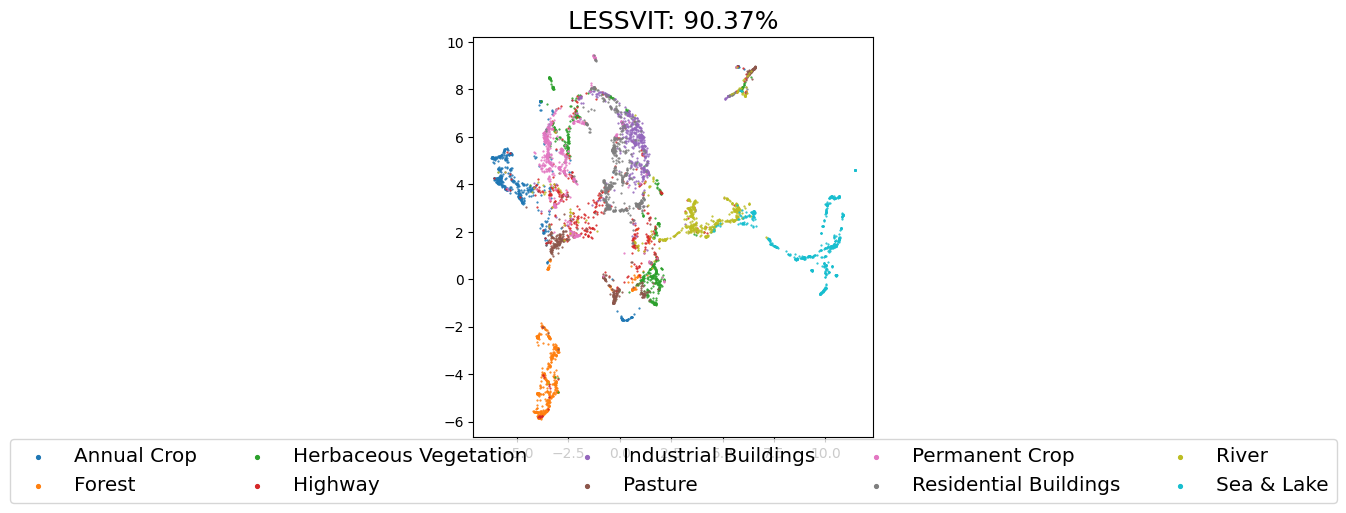

In [17]:
# for every model, plot the UMAP embedding
vis_order = ['LESSVIT']
n_models = len(method_feature)
fig, ax = plt.subplots(1, n_models, figsize=(4 * n_models, 4))
for i, key in enumerate(vis_order):
    X_embedded = method_feature[key]['umap']
    for j in range(10):
        # ax[i].scatter(X_embedded[method_feature[key]['test']['labels'] == j, 0], X_embedded[method_feature[key]['test']['labels'] == j, 1], label=f'Class {j}', marker='o', s=0.3,)
        ax.scatter(X_embedded[method_feature[key]['test']['labels'] == j, 0], X_embedded[method_feature[key]['test']['labels'] == j, 1], label=f'Class {j}', marker='o', s=0.3,)
    # ax[i].set_title(f"{key}: {method_feature[key]['knn_acc']*100:.2f}%", fontsize=18)
    ax.set_title(f"{key}: {method_feature[key]['knn_acc']*100:.2f}%", fontsize=18)
    # ax[i].legend()
    # ax[i].axis('off')
    # ax[i].set_xticks([])
    # ax[i].set_yticks([])
    # ax[i].set_aspect('')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
# show legend at the bottom center of the complete image
# fig.legend(loc='lower center', ncol=method_feature[key]['n_ys']//2, fontsize='small', bbox_to_anchor=(0.5, -0.12))
# only plot one set of legend without the showing the actuall bbox
fig.legend(EUROSAT_CLS, loc='lower center', ncol=5, fontsize='x-large', bbox_to_anchor=(0.5, -0.19), markerscale=5, scatterpoints=1)
# plt.savefig(f'umap_{dataset}_{modal}.png', dpi=300, bbox_inches='tight')

In [18]:
# # Plot
# plt.figure(figsize=(8, 6))
# for i in range(n_ys):
#     plt.scatter(X_embedded[label['test'] == i, 0], X_embedded[label['test'] == i, 1], label=f'Class {i}', marker='.', s=1)
# # set the title
# plt.title(f'UMAP visualization of {dataset} dataset using {model_name} model with {modal} data')
# # put the legend at the botton of the figure
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=5)
# plt.show()

In [18]:
# y_pred = knn.predict(feature['test'])

In [21]:
# accuracy = accuracy_score(label['test'], y_pred)
# print(f"Accuracy: {accuracy*100:.2f}%")

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature['test'])

NameError: name 'feature' is not defined

In [43]:
kmeans = KMeans(n_clusters=n_ys, random_state=42, n_init=10)

In [44]:
kmeans.fit(X_scaled)

# Make predictions
y_kmeans = kmeans.predict(X_scaled)

In [45]:
conf_matrix = confusion_matrix(label['test'], y_kmeans)
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

In [46]:
conf_matrix, row_ind, col_ind

(array([[209,   0,  29,   0,   0,   0, 367,   2,   6,   0],
        [266,   0,   0,   1,   0,   0,   0, 336,   2,   0],
        [ 94,   0,  55,  17,  17,   2, 198, 186,  41,  18],
        [ 88,   0, 193,  28,   1,   0,  63,  74,  26,  26],
        [  1,   0,  60,   3,   0,   0,  13,   0,  50, 380],
        [352,   0,   7,   3,   0,   0,   2,  45,   0,   0],
        [151,   0,  32,   1,   0,   0, 285,   3,   9,   0],
        [ 17,   0, 354,   1,   0,   0,  67,   9,  68,  67],
        [  7,   2,   8, 285, 198,   1,   2,   3,   4,   1],
        [  0, 343,   2,   1,   3, 213,   0,   1,   1,   0]]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([6, 7, 4, 8, 9, 0, 5, 2, 3, 1]))

In [47]:
mapped_cluster_labels = np.zeros_like(y_kmeans)
for i, j in enumerate(col_ind):
    mapped_cluster_labels[y_kmeans == j] = i

# Calculate accuracy
accuracy = accuracy_score(label['test'], mapped_cluster_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 45.56%
